<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Оценка-стационарности-ряда-с-помощью-теста-Дики-Фуллера" data-toc-modified-id="Оценка-стационарности-ряда-с-помощью-теста-Дики-Фуллера-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Оценка стационарности ряда с помощью теста Дики-Фуллера</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-модели-на-адекватность:" data-toc-modified-id="Проверка-модели-на-адекватность:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка модели на адекватность:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Прогнозирование заказов такси

## 1. Подготовка

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller

RANDOM_STATE = 42

In [6]:
path1 = '/datasets/taxi.csv'
path2 = 'C:/Users/kseno/OneDrive/Desktop/taxi.csv'

if os.path.exists(path1):
    taxi = pd.read_csv(path1, parse_dates=['datetime'], index_col=['datetime'])
elif os.path.exists(path2):
    taxi = pd.read_csv(path2, parse_dates=['datetime'], index_col=['datetime'])
else:
    print('Что-то пошло не так')
    
taxi.sort_index(inplace=True)

In [7]:
# Ресемплирование по 1 часу
taxi = taxi.resample('1h').sum()

## 2. Анализ

In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [11]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [12]:
decomposed = seasonal_decompose(taxi)

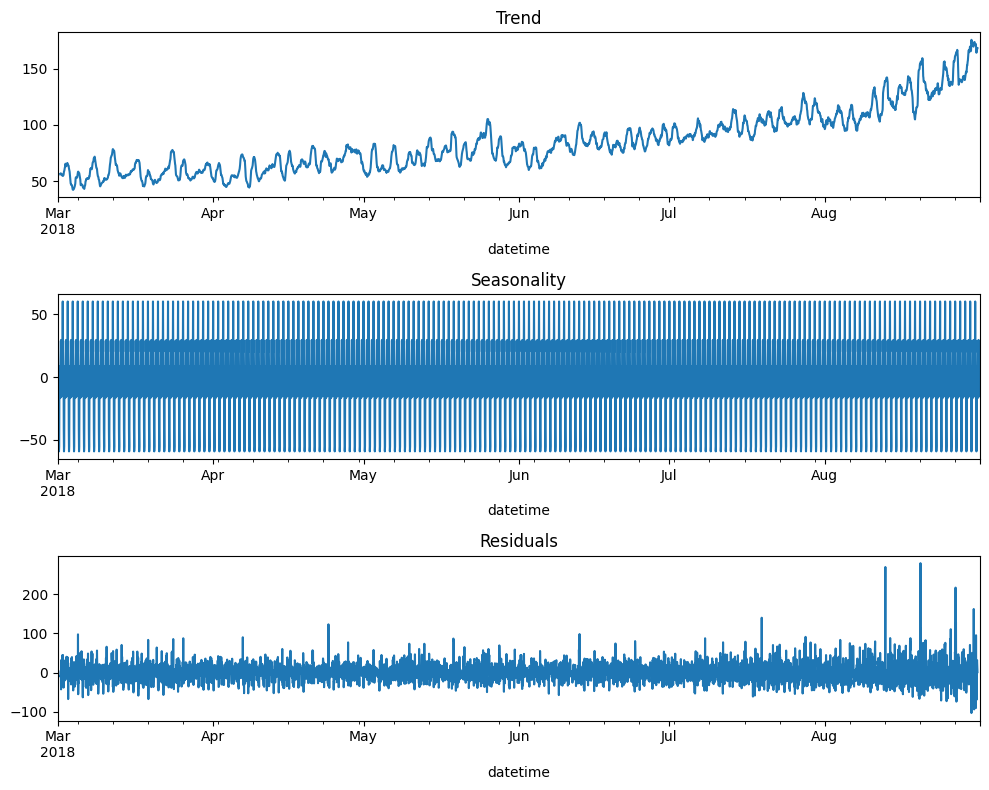

In [13]:
# Построение графиков тренда, сезонности и остатков
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(3, 1, 2)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(3, 1, 3)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

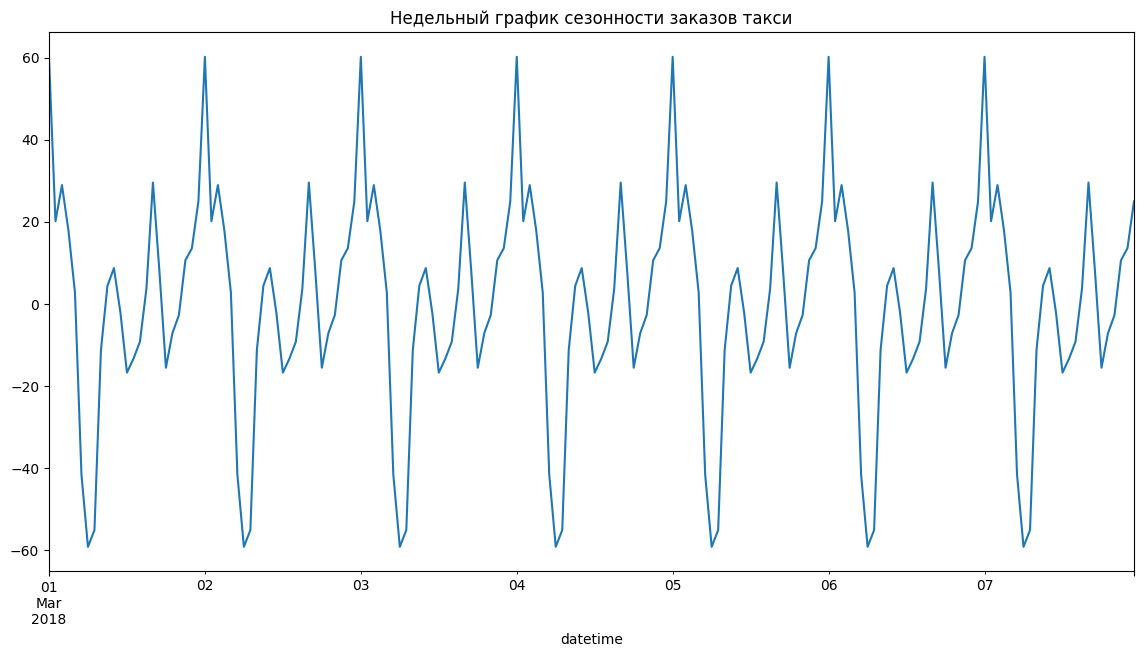

In [14]:
plt.figure(figsize=(14, 7))
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Недельный график сезонности заказов такси')
plt.show()

In [15]:
df_1 = taxi.copy()
df_1['mean'] = df_1.shift().rolling(60).mean()

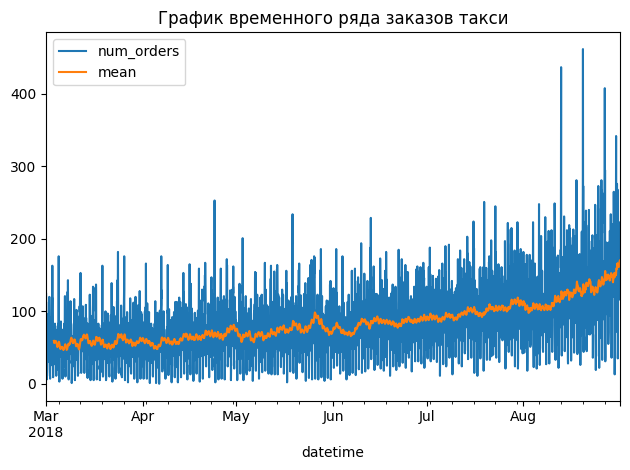

In [16]:
df_1.plot()
plt.title('График временного ряда заказов такси')
plt.tight_layout()
plt.show()

In [17]:
df_2 = taxi.copy()
df_2 = df_2 - df_2.shift(fill_value=0)
df_2['mean'] = df_2['num_orders'].rolling(60).mean()
df_2['std'] = df_2['num_orders'].rolling(60).std()

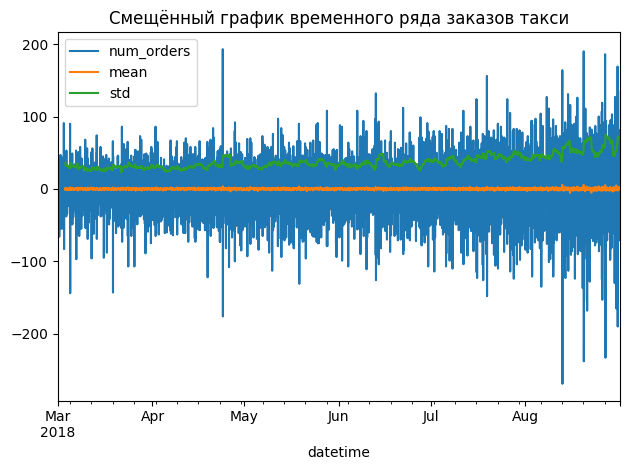

In [18]:
df_2.plot()
plt.title('Смещённый график временного ряда заказов такси')
plt.tight_layout()
plt.show()

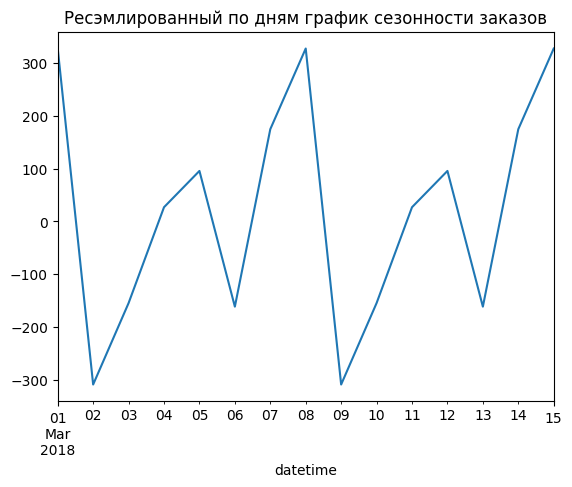

In [19]:
taxi_days = taxi.copy()
taxi_days = taxi_days['2018-03-01':'2018-03-15'].resample('1D').sum()
decomposed = seasonal_decompose(taxi_days)
decomposed.seasonal.plot()
plt.title('Ресэмлированный по дням график сезонности заказов')
plt.show()

### 2.1. Оценка стационарности ряда с помощью теста Дики-Фуллера

Гипотезы:
* H$_0$: временной ряд нестационарный.
* H$_1$: временной ряд стационарный.

In [22]:
alpha = .05
adf_test = adfuller(taxi['num_orders'])
p_value = adf_test[1]
print('p-value = ', p_value)
if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Отвергнуть нулевую гипотезу нельзя")

p-value =  0.02894005140261326
Отвергаем нулевую гипотезу


**Выводы:**
- данные представлены с 2018-03-01 00:00:00 по 2018-08-31 23:00:00 (5 месяцев);
- пропусков нет;
- количество заказов имеет восходящий тренд, с ускорением в августе, происходит устойчивый рост спроса на такси;
- в данных есть регулярные колебания в течении дня, самый высокий спорс приходится на полночь, самый низкий на утро;
- так же есть сезонные колебания по дням недели: четверг самый активный день по количеству заказов, а в пятницу наоборот - меньше всего заказов;
- остатки выглядят случайными, но есть всплески в конце периода, возможно это какие-то события, которые влияют на количество заказов;
- для оценки стационарности ряда был проведён тест Дики-Фуллера, по его результатам ряд является стационарным.

## 3. Обучение

In [25]:
# Функция для создания новых признаков
def make_features(taxi, max_lag, rolling_mean_size):
    df = taxi.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.dayofweek.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df.dropna()

In [26]:
# Применение функции и подбор признаков
taxi_new = make_features(taxi, 22, 24)

In [27]:
# Подбор гиперпараметров
train, test = train_test_split(taxi_new, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

cv = TimeSeriesSplit(n_splits=5).split(X_train)

pipe_final = Pipeline([
    ('scaler', 'passthrough'),
    ('model', LinearRegression())])

params = [{
        'model': [LinearRegression()],
        'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20]
    },
    {'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)],
        'model__iterations': [100, 200],
        'model__learning_rate': [0.01, 0.1]
    }
]

grid_search = GridSearchCV(
    pipe_final,
    params,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [28]:
# Обучение моделей
grid_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit._split at 0x000002F47467BDF0>,
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LinearRegression()],
                          'scaler': [StandardScaler(), MinMaxScaler(),
                                     'passthrough']},
                         {'model': [RandomForestRegressor(random_state=42)],
                          'model__max_depth': [None, 10, 20],
                          'model__n_estimators': [100, 200]},
                         {'model': [<catboost.core.CatBoostRegressor object at 0x000002F477607B90>],
                          'model__iterations': [100, 200],
                          'model__learning_rate': [0.01, 0.1]}],
             scoring='neg_root_mean_squared_error')

In [29]:
best_model = grid_search.best_estimator_
'Лучшая модель и её параметры', best_model

('Лучшая модель и её параметры',
 Pipeline(steps=[('scaler', 'passthrough'),
                 ('model',
                  <catboost.core.CatBoostRegressor object at 0x000002F477605670>)]))

In [30]:
'Метрика лучшей моделии на кросс-валидации', grid_search.best_score_

('Метрика лучшей моделии на кросс-валидации', -27.479793668912475)

**Вывод:**
- подготовлена функция для создания признаков;
- в пайплайне были обучены модели: `LinearRegression`, `RandomForestRegressor` и `CatBoostRegressor`;
- для них были подобраны гиперпараметры;
- лучшей оказалась модель `CatBoostRegressor`;
- её метрика на кросс-валидации составила 27.

## 4. Тестирование

In [33]:
# Получение предсказаний на лучшей модели
y_pred = best_model.predict(X_test)

In [34]:
rmse = root_mean_squared_error(y_test, y_pred)
'Метрика лучшей модели на тестовых данных', rmse

('Метрика лучшей модели на тестовых данных', 47.92787720532873)

### 4.1. Проверка модели на адекватность:

In [36]:
pred_median = np.ones(y_test.shape) * y_train.median()
rmse = root_mean_squared_error(y_test, pred_median)
'Метрика RMSE при предсказании константой', rmse

('Метрика RMSE при предсказании константой', 87.21093811714634)

In [37]:
pred_shift = y_test.shift()
pred_shift.iloc[0] = y_train.iloc[-1]
rmse = root_mean_squared_error(y_test, pred_shift)
'Метрика RMSE при прогнозировании предыдущим значением ряда', rmse

('Метрика RMSE при прогнозировании предыдущим значением ряда',
 58.881776776551476)

**Вывод:**
- метрика RMSE лучшей модели (`CatBoostRegressor`) на тестовых данных составляет 48;
- метрика RMSE при предсказании константой: 87;
- метрика RMSE при прогнозировании предыдущим значением ряда: 59;
- модель прошла тест на адекватность, её метрика значительно лучше.